Using device: cuda


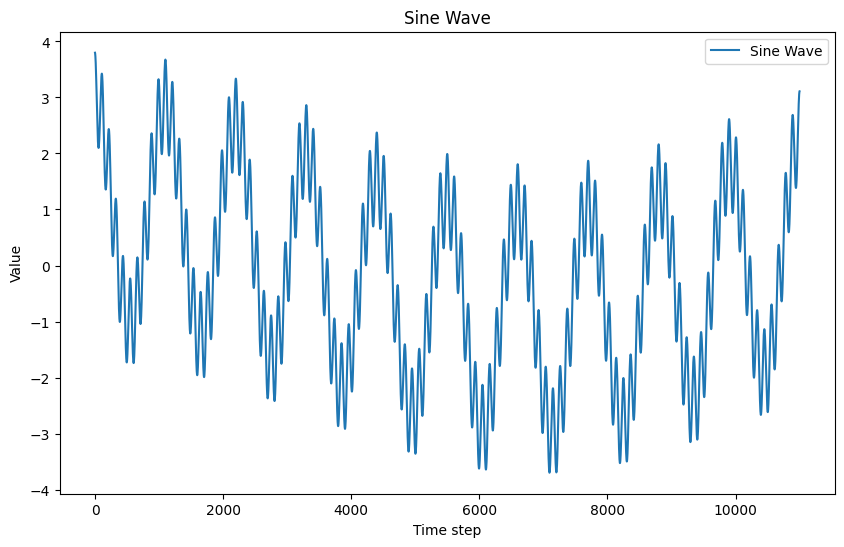

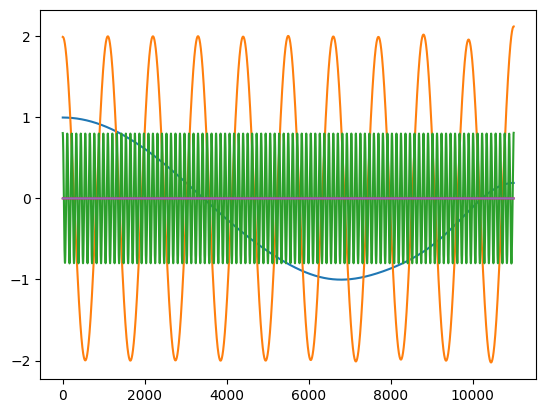

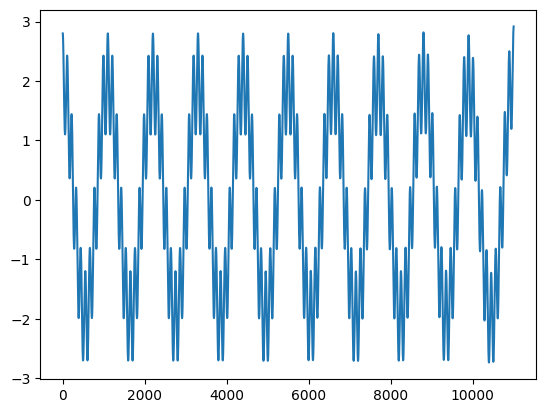

Decomposed data shape: (11000,)
Number of full sequences: 11000
(176, 50, 1)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import ewtpy
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        output, (hidden, cell) = self.lstm(input_seq)
        return hidden, cell

# Step 2: Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden, cell):
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))  # Squeeze the sequence dimension
        return prediction.unsqueeze(0), hidden, cell

# Step 3: Define the Seq2Seq model class with Teacher Forcing
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size = source_seq.shape[1]
        output_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(target_seq_len, batch_size, output_size).to(source_seq.device)

        hidden, cell = self.encoder(source_seq)

        decoder_input = torch.zeros(1, batch_size, source_seq.shape[-1]).to(source_seq.device)

        for t in range(target_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = output
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            decoder_input = output if not use_teacher_forcing else source_seq[t].unsqueeze(0)

        return outputs

# Step 4: Generate and Decompose Sine Wave Data using EWT
def ewt_decompose(signal, N):
    # Perform Empirical Wavelet Transform (EWT) decomposition
    ewt, mfb, boundaries = ewtpy.EWT1D(signal, N=N)
    return ewt

# Function to generate and decompose sine wave data
def generate_ewt_sine_data(seq_len=50, n_samples=100000, N=5):
    """
    Generate and decompose sine wave data for use in PyTorch models.
    """
    # Generate sine wave signal
    x = np.arange(1, n_samples + 1) / n_samples
    y = np.cos(2 * np.pi * 0.8 * x) + 2 * np.cos(2 * np.pi * 10 * x) + 0.8 * np.cos(2 * np.pi * 100 * x)

    # Plot the sine wave
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="Sine Wave")
    plt.title("Sine Wave")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Decompose sine wave using EWT
    decomposed_data = ewt_decompose(y, N=N)  # Decomposed into N components

    plt.plot(decomposed_data)
    plt.show()
    y = y - decomposed_data[:, 0]  # Remove the first component from the original signal
    decomposed_data = y
    decomposed_data.reshape
    #y = y.reshape(-1, 1)
    plt.plot(decomposed_data)
    plt.show()
    print(f"Decomposed data shape: {decomposed_data.shape}")

    # Calculate the total number of full sequences that fit seq_len
    total_samples = y.shape[0]
    num_full_sequences = (total_samples // seq_len) * seq_len
    print(f"Number of full sequences: {num_full_sequences}")

    if num_full_sequences == 0:
        raise ValueError(f"Not enough samples ({total_samples}) to create sequences of length {seq_len}. "
                         f"Consider increasing `n_samples` or reducing `seq_len`.")

    # Trim the decomposed data to fit full sequences
    decomposed_data = decomposed_data[:num_full_sequences]
    num_chunks = num_full_sequences // seq_len
    decomposed_data = decomposed_data.reshape(num_chunks, seq_len, 1)

    # Split the data into training and testing sets (80% training, 20% testing)
    split_idx = int(0.8 * num_chunks)
    X_train = decomposed_data[:split_idx]
    X_test = decomposed_data[split_idx:]

    print(X_train.shape)

    # create y ahead of X
    

    # Convert data to PyTorch tensors and send to the appropriate device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    return X_train_tensor, X_test_tensor

# Step 5: Create a DataLoader for batching
def create_dataloader(X, batch_size=32):
    dataset = TensorDataset(X, X)  # Since it's autoencoding, input == target
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Step 6: Training the Seq2Seq model
def train_seq2seq(model, dataloader, epochs=100, learning_rate=0.001, teacher_forcing_ratio=0.5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()

        for batch_idx, (batch_X, _) in enumerate(dataloader):
            optimizer.zero_grad()

            # batch_X shape should be [batch_size, seq_len, features]
            batch_X = batch_X.permute(1, 0, 2)  # Ensure [seq_len, batch_size, features]

            outputs = model(batch_X, batch_X.shape[0], teacher_forcing_ratio)
            
            loss = criterion(outputs, batch_X)  # No need to permute here
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

# Step 7: Evaluation with plotting multiple sequences
def evaluate_seq2seq(model, X_test, num_sequences_to_plot=5):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.permute(1, 0, 2), X_test.shape[1], teacher_forcing_ratio=0.0)
        predictions = predictions.permute(1, 0, 2).cpu().numpy()  # Convert to numpy for plotting
        X_test = X_test.cpu().numpy()  # Convert to numpy for plotting

        # Plot the actual and predicted sequences for the first EWT component
        plt.figure(figsize=(12, 8))
        
        num_sequences = min(num_sequences_to_plot, X_test.shape[0])  # Determine how many sequences to plot
        
        for i in range(num_sequences):
            plt.subplot(num_sequences, 1, i+1)
            plt.plot(X_test[i, :, 0], label=f"Actual Sequence {i+1} (First EWT Component)", color='green')
            plt.plot(predictions[i, :, 0], label=f"Predicted Sequence {i+1} (First EWT Component)", linestyle=":", color='red')
            plt.title(f"Actual vs Predicted Decomposed Sequence {i+1} (First EWT Component)")
            plt.xlabel("Time step")
            plt.ylabel("Value")
            plt.legend()

        plt.tight_layout()
        plt.show()

# Step 8: Putting it all together
if __name__ == "__main__":
    # Generate EWT-decomposed sine wave data
    X_train, X_test = generate_ewt_sine_data(seq_len=50, n_samples=11000, N=5)

    # Define the model parameters
    input_size = X_train.shape[-1]  # Number of decomposed EWT components
    hidden_size = 64
    output_size = input_size  # Same number of components in the output

    # Initialize Encoder, Decoder, and Seq2Seq model
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(input_size, hidden_size, output_size).to(device)
    seq2seq_model = Seq2Seq(encoder, decoder).to(device)

    # Create DataLoader
    dataloader = create_dataloader(X_train, batch_size=32)

    # Train the model
    #train_seq2seq(seq2seq_model, dataloader, epochs=200, learning_rate=0.001, teacher_forcing_ratio=0.5)

    # Evaluate and plot
    #evaluate_seq2seq(seq2seq_model, X_test)
